## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

Because I have massive `overfitting` problems (and / or `exploding` keypoints in inference with non training or testing images) I decided to `split` the training data in train and validation data and update my training routine accordingly to efficiently detect overfitting. 

I decided to split the training data into `train` and `validation` set.

In [1]:
# split training data into training and validation
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
from inception_net import StaticInceptionNet
from optuna_objectives.conf_baseline_model import objective_baseline_model

def split_csv_train_val(csv_file, train_file, val_file, val_size=0.25):
    """
    Reads in a CSV file, splits it into training and validation portions, 
    and writes each portion to separate CSV files.
    
    Args:
    - csv_file (str): Path to the CSV file.
    - train_file (str): Path where the training portion CSV will be saved.
    - val_file (str): Path where the validation portion CSV will be saved.
    - test_size (float): Fraction of the dataset to allocate to validation.
    
    The CSV file is expected to have the format described by the user.
    """
    # Read in the full CSV dataset
    data = pd.read_csv(csv_file)

    # Split the data into training and validation sets, with shuffling
    train_data, val_data = train_test_split(data, test_size=val_size, shuffle=True, random_state=42)

    # Save the new datasets to CSV files
    train_data.to_csv(train_file, index=False)
    val_data.to_csv(val_file, index=False)

# Example usage:
split_csv_train_val('data/training_frames_keypoints.csv', 'data/train_data.csv', 'data/val_data.csv', val_size=0.25)


/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2


In [18]:
from hourglass import StackedHourglass
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from flexible_inception_net import FlexibleInceptionNet
from inception_net_config import inception_config1
import numpy as np
import random

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the seed for PyTorch
seed_value = 42
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the seed for NumPy
np.random.seed(seed_value)

# Set the seed for Python's random module
random.seed(seed_value)

# If you're using GPU, also set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU setups
    
## Once you've defined the network, you can instantiate it
# one example conv layer has been provided for you

# model = ConfigurableBaseLineModel(
#     num_keypoints=68,
#     out_channels=[8, 16, 32],
#     kernel_sizes=[3, 3, 3],
#     dropout_rate=0.2,
#     spatial_transform=True,
#     use_batch_norm=True)

model = FlexibleInceptionNet(
    num_keypoints=68, 
    use_spatial_transform=True, 
    use_residual=False, 
    inception_configs=inception_config1, 
    use_aux=True)

# model = StackedHourglass(
#     num_keypoints=68,
#     num_channels=64,
#     depth=4,
#     stacks=2,
#     spatial_transform=True,
#     use_aux_classifier=True
# )

model.to(device)

Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet


FlexibleInceptionNet(
  (stn): Resnet18SpatialTransformer(
    (localization): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [19]:
import matplotlib.pyplot as plt
from data_load import Resize, RandomCrop, Normalize, ToTensor, RandomRotate, RandomHorizontalFlip, FaceCrop, \
    FacialKeypointsDataset, RandomFaceCropAndResize, RandomRescale, GaussianBlur, GrayscaleJitter, Sharpen
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# I calculated the mean and std for z-norm standardization (stabilizes the net gradient flow)
def calculate_mean_std(train_loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for batch in train_loader:
        images = batch['image']  # Extract images from the batch dictionary
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)  # Flatten the image (C, H, W) -> (C, H*W)

        # Calculate batch mean and std
        batch_mean = images.mean(dim=[0, 2])
        batch_std = images.std(dim=[0, 2])

        mean += batch_mean * batch_size
        std += batch_std * batch_size
        total_images_count += batch_size

    mean /= total_images_count
    std /= total_images_count

    return mean, std

def prepare_data_pipeline(batch_size=32, mean=None, std=None, debug=False):
    train_transform = transforms.Compose(
        [
         #GaussianBlur(kernel_size=(3, 3), sigma=0.5),
         #Sharpen(method='unsharp', strength=1.5, blur_size=(3, 3)),  # Apply sharpening after Gaussian blur
         Resize(250),
         #RandomRescale(scale_range=(0.8, 1.2)),  # Scale the image up or down slightly
         RandomCrop((224, 224)),
         #Resize((224, 224)),         
         #RandomFaceCropAndResize(padding=face_padding, output_size=(224, 224), prob=1.0), # not needed, I use a spatial transformer for that         
         #RandomRotate((-10, 10), prob=1.0), # not good, disturbs the net
         RandomHorizontalFlip(prob=0.5),
         Normalize(mean, std),
         ToTensor()])

    valid_transform = transforms.Compose(
        [Resize((224, 224)),
         Normalize(mean, std),
         ToTensor()])

    test_transform = transforms.Compose(
        [Resize((224, 224)),         
         Normalize(mean, std),
         ToTensor()])

    # create the transformed datasets
    training_dataset = FacialKeypointsDataset(csv_file='data/train_data.csv',
                                              root_dir='data/training/',
                                              transform=train_transform)

    validation_dataset = FacialKeypointsDataset(csv_file='data/val_data.csv',
                                                root_dir='data/training/',
                                                transform=valid_transform)

    test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                          root_dir='data/test/',
                                          transform=test_transform)

    print('Number of images in training set:', len(training_dataset))
    print('Number of images in validation set:', len(validation_dataset))

    train_loader = DataLoader(training_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=4)

    valid_loader = DataLoader(validation_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=4)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=4)

    if debug:
        def show_images_with_keypoints(loader, title):
            batch = next(iter(loader))
            images = batch['image'][:5]
            keypoints = batch['keypoints'][:5]

            keypoints = (keypoints*50)+100

            fig, axs = plt.subplots(1, 5, figsize=(15, 3))
            fig.suptitle(title, fontsize=16)
            for i, (img, kpts) in enumerate(zip(images, keypoints)):
                axs[i].imshow(img.squeeze(), cmap='gray')
                axs[i].scatter(kpts[:, 0], kpts[:, 1], s=10, marker='.', c='r')
                axs[i].axis('off')
            plt.show()

        print()
        show_images_with_keypoints(train_loader, 'Training Set - First 5 Images with Keypoints')
        print()
        show_images_with_keypoints(valid_loader, 'Validation Set - First 5 Images with Keypoints')
        print()
        show_images_with_keypoints(test_loader, 'Test Set - First 5 Images with Keypoints')
        print()

    return train_loader, valid_loader, test_loader


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of images in training set: 2596
Number of images in validation set: 866



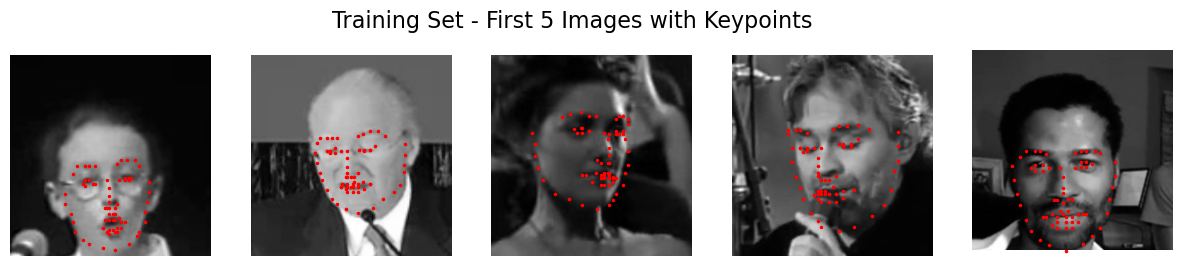

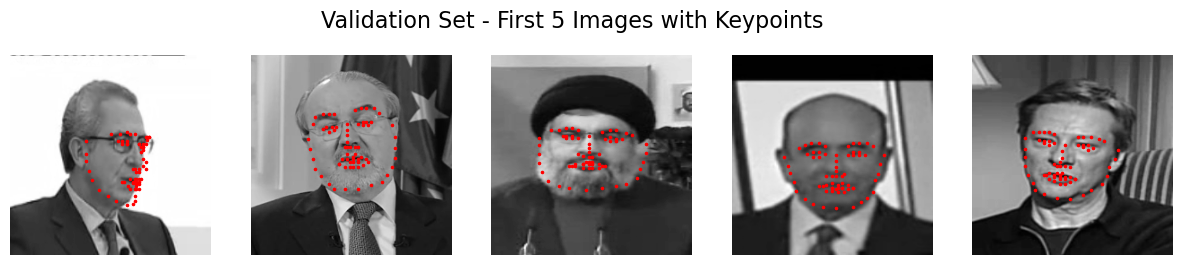

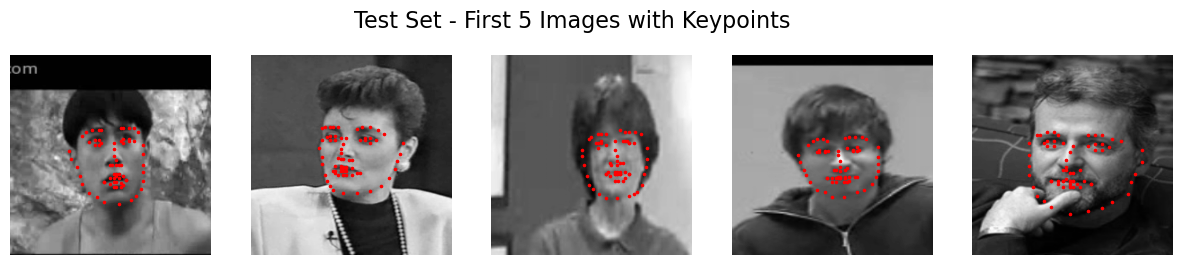


Mean: tensor([0.3621])
Std Dev: tensor([0.2333])


In [20]:
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

# test the pipeline
mean_std_loader, _, _ = prepare_data_pipeline(batch_size=32, debug=True)#, mean=0.5, std=0.5)

# this here is for getting the mean and std from the training set
dataset_mean, dataset_std = calculate_mean_std(mean_std_loader)
# mean=0.3617, std=0.2329
print("Mean:", dataset_mean)
print("Std Dev:", dataset_std)

Some `debug` functions:

In [5]:
import torch
import numpy as np
import cv2

def check_image(image):
    """
    Test a numpy image for:
    a) Is it grayscale or not?
    b) Are values normalized or not?
    c) What are the dimensions of the image?
    
    Args:
    - image (ndarray): Input numpy array representing an image.
    
    Returns:
    None. Prints the results of the checks.
    """

    # Check if the image is grayscale
    if len(image.shape) == 2:
        print("Image is grayscale.")
    elif len(image.shape) == 3 and image.shape[0] == 1:
        print("Image is grayscale with a single channel dimension.")
    else:
        print("Image is not grayscale.")

    # Check if the values are normalized (between 0 and 1)
    if image.min() >= 0.0 and image.max() <= 1.0:
        print("Image values are normalized (between 0 and 1).")
    else:
        print(f"Image values are NOT normalized. Range: [{image.min()}, {image.max()}]")

    # Print the dimensions of the image
    print(f"Image dimensions: {image.shape}")



In [6]:
def check_predicted_keypoints(predicted_keypoints, sample_size=10, details=True):
    """
    Check if the predicted keypoints are within the desired range (e.g., [-1, 1]).

    Args:'
    - predicted_keypoints (torch.Tensor or list of ndarrays): Predicted keypoints from the model.
    - sample_size: Number of samples to check (default: 10).
    - details: If True, prints details for each sample.

    Prints a summary of how many (x, y) pairs are out of the expected range, 
    and also displays the minimum and maximum values for the keypoints in each sample.
    """
    total_samples_checked = 0
    total_violations = 0
    min_value_all_samples = float('inf')
    max_value_all_samples = float('-inf')

    # Iterate over the predictions for a given sample size or all predictions
    for i in range(min(sample_size, len(predicted_keypoints))):
        # Get the predicted keypoints for this sample
        keypoints = predicted_keypoints[i]

        # Check if keypoints is a PyTorch tensor, convert to numpy if necessary
        if isinstance(keypoints, torch.Tensor):
            keypoints = keypoints.cpu().numpy()

        # Count how many (x, y) pairs are out of range (assuming desired range is [-1, 1])
        num_out_of_range = np.sum((keypoints < -1) | (keypoints > 1))

        # Get min and max values for the keypoints in this sample
        min_val = np.min(keypoints)
        max_val = np.max(keypoints)
        min_value_all_samples = min(min_value_all_samples, min_val)
        max_value_all_samples = max(max_value_all_samples, max_val)

        if num_out_of_range > 0 and details:
            print(f"Sample {i}: {num_out_of_range} keypoints out of range.")

        # Print the min and max values for each sample
        if details:
            print(f"Sample {i} - Min value: {min_val}, Max value: {max_val}")

        total_violations += num_out_of_range
        total_samples_checked += 1

    # Print summary
    print(f"\nChecked {total_samples_checked} samples.")
    print(f"Total keypoints out of range: {total_violations}")
    print(f"Overall min keypoint value: {min_value_all_samples}")
    print(f"Overall max keypoint value: {max_value_all_samples}")

    if total_violations == 0:
        print("All keypoints in all samples are correctly within the expected range.")

    print()
    
def test_keypoints_normalization(dataset, sample_size=10, details=True):
    """
    Test routine to check if the normalized keypoints are within the range [-1, 1].
    
    Args:
    - dataset: an instance of the FacialKeypointsDataset with transformations applied.
    - sample_size: number of samples to check (default: 10).
    - details: whether to print detailed per-sample information (default: True).
    
    Prints a summary of how many (x, y) pairs are out of the [-1, 1] range for each sample,
    and displays the overall minimum and maximum keypoint values across all samples.
    """
    total_samples_checked = 0
    total_violations = 0

    overall_min_val = float('inf')
    overall_max_val = float('-inf')

    # Iterate over the dataset for a given sample size or the full dataset
    for i in range(min(sample_size, len(dataset))):
        sample = dataset[i]

        # Extract keypoints from the sample
        keypoints = sample['keypoints']

        # Check if keypoints is a PyTorch tensor, convert to numpy if necessary
        if isinstance(keypoints, torch.Tensor):
            keypoints = keypoints.numpy()

        # Count how many (x, y) pairs are out of range
        num_out_of_range = np.sum((keypoints < -1) | (keypoints > 1))

        # Get min and max values for the keypoints in this sample
        min_val = np.min(keypoints)
        max_val = np.max(keypoints)

        # Update overall min and max values
        overall_min_val = min(overall_min_val, min_val)
        overall_max_val = max(overall_max_val, max_val)

        if num_out_of_range > 0 and details:
            print(f"Sample {i}: {num_out_of_range} keypoints out of range.")

        # Print the min and max values for each sample
        if details:
            print(f"Sample {i} - Min value: {min_val}, Max value: {max_val}")

        total_violations += num_out_of_range
        total_samples_checked += 1

    # Print summary of all checked samples
    print(f"\nChecked {total_samples_checked} samples.")
    if total_violations == 0:
        print("All keypoints in all samples are correctly normalized between [-1, 1].")
    else:
        print(f"Total keypoints out of range: {total_violations}")

    # Print overall min and max values across all samples
    print(f"Overall Min value across all samples: {overall_min_val}")
    print(f"Overall Max value across all samples: {overall_max_val}")


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

Number of images in training set: 2596
Number of images in validation set: 866



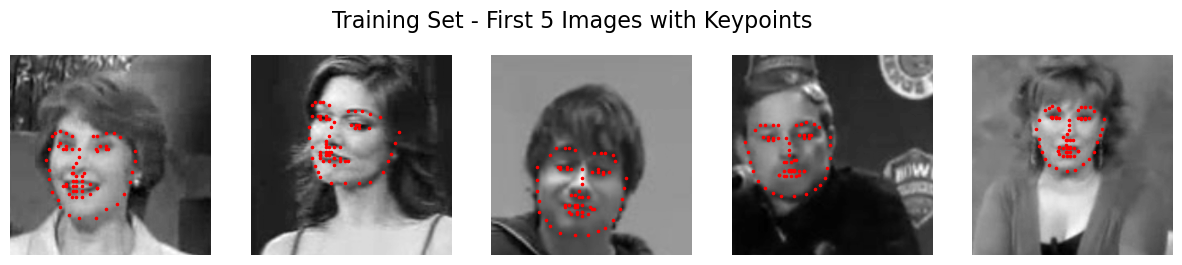

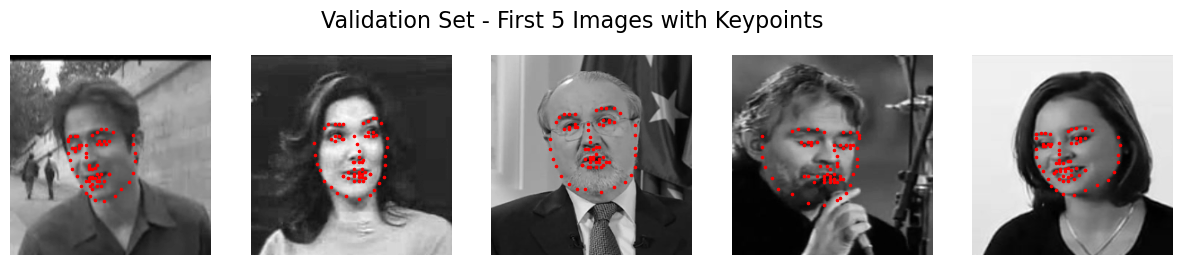

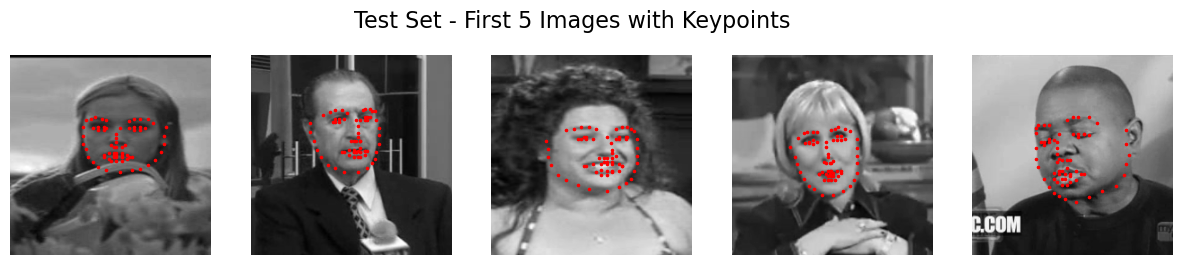

In [21]:
# load training data in batches
batch_size = 32

# mean=0.3617, std=0.2329

train_loader, valid_loader, test_loader = prepare_data_pipeline(batch_size=batch_size, mean=0.3617, std=0.2329)

def show_images_with_keypoints(loader, title, batch_size=5):
    batch = next(iter(loader))
    images = batch['image'][:batch_size]    
    keypoints = batch['keypoints'][:batch_size]
    
    keypoints = (keypoints*50)+100

    fig, axs = plt.subplots(1, batch_size, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i, (img, kpts) in enumerate(zip(images, keypoints)):  
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].scatter(kpts[:, 0], kpts[:, 1], s=10, marker='.', c='r')
        axs[i].axis('off')
    plt.show()

print()
show_images_with_keypoints(train_loader, 'Training Set - First 5 Images with Keypoints')
print()
show_images_with_keypoints(valid_loader, 'Validation Set - First 5 Images with Keypoints')
print()
show_images_with_keypoints(test_loader, 'Test Set - First 5 Images with Keypoints')
print()


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range.

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [22]:
# test the model on a batch of test images
def net_sample_output(model, loader):
    
    model.eval()
    
    # iterate through the test dataset
    for i, samples in enumerate(loader):
        
        # get sample data: images and ground truth keypoints
        images = samples['image']
        key_pts = samples['keypoints']
        names = samples['name']
        
        key_pts.to(device)                
        
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.to(device)
        model.to(device)

        # Forward pass to get net output
        with torch.no_grad():  # Disable gradient calculation for inference
            output_pts, _, _ = model(images)

        #check_predicted_keypoints(output_pts, details=True)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts, names
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [23]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts, _ = net_sample_output(model, train_loader)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [24]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

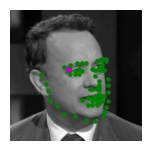

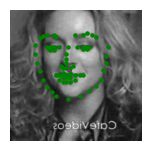

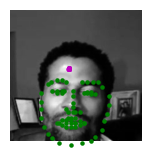

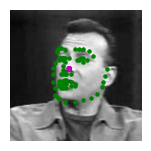

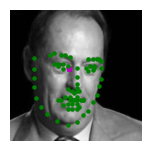

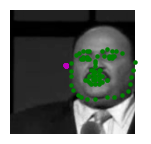

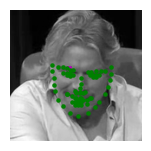

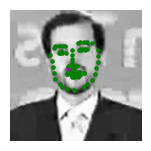

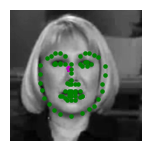

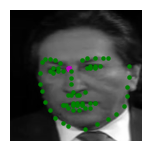

In [25]:
import numpy as np

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data.cpu()   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts * 50.0 + 100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts * 50.0 + 100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

#plt.show()

# call it
visualize_output(test_images, test_outputs, gt_pts, 10)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](https://pytorch.org/docs/master/nn.html#loss-functions).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [11]:
# both are defined below in a later cell


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [26]:
def plot_epoch_loss(train_losses, valid_losses=None):
    plt.figure(figsize=(10, 5))

    # Plot both training and validation losses
    plt.plot(train_losses, label="Training Loss", color='blue')
    if valid_losses is not None:
        plt.plot(valid_losses, label="Validation Loss", color='orange')

    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Average Training and optional Validation Loss per Epoch")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [27]:
def check_gradients(layer, layer_name):
    if layer.weight.grad is None:
        print(f"Gradients for {layer_name} are not available (None).")
        return

    # Flatten the gradient tensor to make it easier to analyze
    grad_flattened = layer.weight.grad.view(-1)

    # Count how many gradients are exactly zero
    num_zeros = (grad_flattened == 0).sum().item()

    # Count the total number of gradients
    total_gradients = grad_flattened.numel()

    # Report the number of zero and non-zero gradients
    print(f"Layer: {layer_name}")
    print(f"Number of zero gradients: {num_zeros}/{total_gradients}")
    print(f"Percentage of zero gradients: {num_zeros / total_gradients * 100:.2f}%\n")

In [28]:
import copy

def train_net(model, n_epochs, optimizer, criterion, train_loader, valid_loader=None,
              patience=5, lr_scheduler=None, lambda_reg=None, max_norm_gradient_clipping=None, logging=False, trial=None):
    model.to(device)  # Move the network to the GPU if available
    
    if valid_loader is None:
        raise Exception("Valid loader is None")
    
    # Lists to store losses per epoch
    train_losses = []
    valid_losses = []

    # Early stopping setup
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0
    global_step = 0

    if lambda_reg is None:
        lambda_reg = 1e-5
        
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        train_batch_count = 0

        for batch_i, data in enumerate(train_loader):
            # Increment global step
            global_step += 1

            # Get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # Move the inputs and targets to the GPU
            images = images.to(device)
            key_pts = key_pts.to(device)

            # Flatten keypoints
            key_pts = key_pts.view(key_pts.size(0), -1)

            # Zero the parameter (weight) gradients
            optimizer.zero_grad()

            # Forward pass
            output_pts, aux_outputs, theta = model(images, writer, global_step, logging=logging)

            # Calculate keypoint loss
            keypoint_loss = criterion(output_pts, key_pts)
            
            aux_losses = []
            
            # Compute auxiliary losses (only if outputs are not None)
            if aux_outputs is not None:
                for aux_output in aux_outputs:
                    aux_losses.append(criterion(aux_output, key_pts))
                
            #aux2_loss = criterion(aux_output2, key_pts) if aux_output2 is not None else 0
            
            # Calculate transformation regularization loss if theta is available            
            if theta is not None:
                identity = torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32).to(theta.device)
                identity = identity.view(1, 2, 3).expand_as(theta)
                transformation_loss = F.l1_loss(theta, identity)
            else:
                transformation_loss = 0
            
            # Combine losses            
            total_loss = keypoint_loss + lambda_reg * transformation_loss #  + 0.3 * aux1_loss + 0.3 * aux2_loss
                
            for aux_loss in aux_losses:
                total_loss += aux_loss * 0.3
                
            # Backward pass and update
            total_loss.backward()

            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            
            if logging:
                writer.add_scalar('Gradient Norm', total_norm, global_step)
            
            if max_norm_gradient_clipping is not None:
                # Gradient clipping
                #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm_gradient_clipping)
                if hasattr(model, 'stn'):
                    torch.nn.utils.clip_grad_norm_(model.stn.parameters(), max_norm=max_norm_gradient_clipping)

            # Perform a training step
            optimizer.step()

            # Log to TensorBoard
            if logging:
                writer.add_scalar("Loss/train", total_loss.item(), global_step)
            
            #if aux_output1 is not None and aux_output2 is not None:
            
            if logging:
                for i, aux_loss in enumerate(aux_losses):
                    writer.add_scalar(f"Loss/Aux{i + 1}", aux_loss.item(), global_step)                    
            
            running_train_loss += total_loss.item()
            train_batch_count += 1

        avg_train_loss = running_train_loss / train_batch_count
        train_losses.append(avg_train_loss)

        # Validation phase (only if validation loader is provided)
        if valid_loader:
            model.eval()
            running_valid_loss = 0.0
            valid_batch_count = 0

            with torch.no_grad():
                for data in valid_loader:
                    images = data['image']
                    key_pts = data['keypoints']

                    images = images.to(device)
                    key_pts = key_pts.to(device)

                    key_pts = key_pts.view(key_pts.size(0), -1)
                    key_pts = key_pts.type(torch.FloatTensor).to(device)
                    images = images.type(torch.FloatTensor).to(device)

                    output_pts, _ , theta = model(images)  # Also get theta in validation

                    # Calculate keypoint loss
                    keypoint_loss = criterion(output_pts, key_pts)

                    # Calculate transformation regularization loss if theta is available
                    if theta is not None:
                        identity = torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32).to(theta.device)
                        identity = identity.view(1, 2, 3).expand_as(theta)
                        transformation_loss = F.l1_loss(theta, identity)
                    else:
                        transformation_loss = 0

                    # Combine losses
                    total_loss = keypoint_loss + lambda_reg * transformation_loss

                    running_valid_loss += total_loss.item()
                    valid_batch_count += 1

            avg_valid_loss = running_valid_loss / valid_batch_count
            valid_losses.append(avg_valid_loss)

            # Adjust learning rate using scheduler, if provided
            if lr_scheduler:
                lr_scheduler.step(avg_valid_loss)  # Reduce LR based on validation loss if using ReduceLROnPlateau

            # Log the updated learning rate
            if logging:
                for idx, param_group in enumerate(optimizer.param_groups):
                    lr = param_group['lr']
                    writer.add_scalar(f'Learning Rate/Group_{idx}', lr, global_step)


            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

            # Log to TensorBoard
            if logging:
                writer.add_scalar("Loss/valid", avg_valid_loss, global_step)

            # Early stopping condition
            if avg_valid_loss < best_loss:
                best_loss = avg_valid_loss
                best_model_wts = copy.deepcopy(model.state_dict())  # Save the best model weights
                epochs_no_improve = 0
                print("Setting best loss so far to {:.4f} and saved the model as best model".format(best_loss))
            else:
                epochs_no_improve += 1
                print(f'Early stopping counter: {epochs_no_improve}/{patience}')

            if epochs_no_improve == patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_wts)  # Load the best model weights
                break

            # **Optuna Pruning**
            if trial:
                trial.report(avg_valid_loss, epoch)
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
                
            model.load_state_dict(best_model_wts)  # Ensure the best model is loaded
        else:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}')
        
        if writer is not None and logging:
            writer.flush()

    print('Finished Training')

    return train_losses, valid_losses if valid_loader else (train_losses, None), best_loss


Introducing `optuna` to automate hyperparameter `trials`. After training days manually I decided to automate things. I will never work without automation libraries again.

In [22]:
import optuna
from optuna_objectives.flex_inception_net import objective_inception_net

writer = None # no logging here
study = optuna.create_study(direction='minimize')

study.optimize(
    lambda trial: objective_inception_net(trial, train_loader, valid_loader, train_net, device, seed_value), n_trials=50)

# After the study
print('Best hyperparameters:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)

[I 2024-11-08 09:34:17,941] A new study created in memory with name: no-name-e8b0219b-dc8b-4cc8-b76c-9b5060277cbc


Using auxiliary classifier in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3620, Validation Loss: 0.1134
Setting best loss so far to 0.1134 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2896, Validation Loss: 0.1170
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2862, Validation Loss: 0.1071
Setting best loss so far to 0.1071 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2454, Validation Loss: 0.1030
Setting best loss so far to 0.1030 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.2156, Validation Loss: 0.1221
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [6/15], Training Loss: 0.2145, Validation Loss: 0.0933
Sett

[I 2024-11-08 09:36:34,136] Trial 0 finished with value: 0.06280154162751776 and parameters: {'lambda_reg': 0.00010311905611249662, 'main_lr': 2.312718077967785e-05, 'stn_lr': 1.7307538887712832e-06, 'aux_lr': 2.273700025938855e-05, 'max_norm': 5.0, 'weight_decay_stn': 3.100187522617398e-05, 'weight_decay_main': 0.00015969177489624168, 'weight_decay_aux': 9.800795564714157e-05, 'use_aux': True, 'use_spatial_transformer': False}. Best is trial 0 with value: 0.06280154162751776.


Epoch [12/15], Training Loss: 0.1833, Validation Loss: 0.0802
Early stopping counter: 5/5
Early stopping triggered at epoch 12
Finished Training
New best model found. Saved to optuna_best_model/best_model_flex_inception_config1_overall.pt with validation loss 0.0628
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3386, Validation Loss: 0.0972
Setting best loss so far to 0.0972 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2507, Validation Loss: 0.0856
Setting best loss so far to 0.0856 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2156, Validation Loss: 0.0422
Setting best loss so far to 0.0422 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15],

[I 2024-11-08 09:39:07,408] Trial 1 finished with value: 0.04215314704924822 and parameters: {'lambda_reg': 3.1353066775943595e-06, 'main_lr': 0.00011216641892416381, 'stn_lr': 3.3818733369701916e-06, 'aux_lr': 2.48346885373583e-05, 'max_norm': None, 'weight_decay_stn': 0.0034672521403731746, 'weight_decay_main': 0.0004417619499669294, 'weight_decay_aux': 0.00040437898382043473, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 1 with value: 0.04215314704924822.


New best model found. Saved to optuna_best_model/best_model_flex_inception_config1_overall.pt with validation loss 0.0422
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3304, Validation Loss: 0.1669
Setting best loss so far to 0.1669 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1992, Validation Loss: 0.1047
Setting best loss so far to 0.1047 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1801, Validation Loss: 0.0893
Setting best loss so far to 0.0893 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1650, Validation Loss: 0.1579
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1696, Validation Loss: 0.0799
Setting best loss so far to 0.0799 and saved the model as best model

[I 2024-11-08 09:40:47,077] Trial 2 finished with value: 0.07985193974205426 and parameters: {'lambda_reg': 1.0238635847207997e-06, 'main_lr': 0.0009478504255131135, 'stn_lr': 1.15353929409583e-06, 'aux_lr': 0.0007248640636528642, 'max_norm': 5.0, 'weight_decay_stn': 0.0002003071613458709, 'weight_decay_main': 1.0242915333925673e-06, 'weight_decay_aux': 2.681510054698827e-06, 'use_aux': False, 'use_spatial_transformer': False}. Best is trial 1 with value: 0.04215314704924822.


Epoch [10/15], Training Loss: 0.1482, Validation Loss: 0.1538
Early stopping counter: 5/5
Early stopping triggered at epoch 10
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3076, Validation Loss: 0.1133
Setting best loss so far to 0.1133 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2123, Validation Loss: 0.0932
Setting best loss so far to 0.0932 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1828, Validation Loss: 0.0570
Setting best loss so far to 0.0570 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1640, Validation Loss: 0.0524
Setting best loss so far to 0.0524 and saved the model as best model
Loadi

[I 2024-11-08 09:45:34,697] Trial 3 finished with value: 0.04446548010621752 and parameters: {'lambda_reg': 3.6978519476614974e-05, 'main_lr': 6.12745140824155e-05, 'stn_lr': 8.439134255559202e-05, 'aux_lr': 0.00013230309854267314, 'max_norm': None, 'weight_decay_stn': 1.0820346686765562e-05, 'weight_decay_main': 4.215203565164931e-05, 'weight_decay_aux': 0.006628043282773908, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 1 with value: 0.04215314704924822.


Epoch [15/15], Training Loss: 0.1469, Validation Loss: 0.1091
Early stopping counter: 1/5
Finished Training
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.1885, Validation Loss: 0.1562
Setting best loss so far to 0.1562 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1290, Validation Loss: 0.0813
Setting best loss so far to 0.0813 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1019, Validation Loss: 0.0601
Setting best loss so far to 0.0601 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.0903, Validation Loss: 0.1069
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.0918, Validation Loss: 0.0635
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg


[I 2024-11-08 09:46:54,949] Trial 4 finished with value: 0.06008103277002062 and parameters: {'lambda_reg': 2.207317763520709e-06, 'main_lr': 0.0003393372241617945, 'stn_lr': 7.941456619186512e-06, 'aux_lr': 0.0006873236634232707, 'max_norm': 1.0, 'weight_decay_stn': 0.00016755570308274367, 'weight_decay_main': 0.0001303627619445353, 'weight_decay_aux': 1.5011675199427673e-06, 'use_aux': False, 'use_spatial_transformer': False}. Best is trial 1 with value: 0.04215314704924822.


Epoch [8/15], Training Loss: 0.1033, Validation Loss: 0.1443
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.1519, Validation Loss: 0.1167
Setting best loss so far to 0.1167 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1189, Validation Loss: 0.1127
Setting best loss so far to 0.1127 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1061, Validation Loss: 0.0550
Setting best loss so far to 0.0550 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1001, Validation Loss: 0.0773
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.0971, 

[I 2024-11-08 09:49:17,697] Trial 5 finished with value: 0.054951552102076154 and parameters: {'lambda_reg': 0.0002766662508474774, 'main_lr': 5.3135703827773466e-05, 'stn_lr': 1.3579683368514304e-06, 'aux_lr': 1.3926072259958507e-05, 'max_norm': None, 'weight_decay_stn': 1.118195489803211e-06, 'weight_decay_main': 5.0856335705843606e-05, 'weight_decay_aux': 0.0004791635341256082, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 1 with value: 0.04215314704924822.


Epoch [8/15], Training Loss: 0.1014, Validation Loss: 0.0701
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.1515, Validation Loss: 0.1148
Setting best loss so far to 0.1148 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1195, Validation Loss: 0.1048
Setting best loss so far to 0.1048 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1067, Validation Loss: 0.0586
Setting best loss so far to 0.0586 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.0998, Validation Loss: 0.0737
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.0962, 

[I 2024-11-08 09:51:40,535] Trial 6 finished with value: 0.058637487036841254 and parameters: {'lambda_reg': 0.00013175079966217966, 'main_lr': 4.762682647537987e-05, 'stn_lr': 7.5956322132950305e-06, 'aux_lr': 1.0897121200834802e-05, 'max_norm': None, 'weight_decay_stn': 0.000689433276711684, 'weight_decay_main': 2.818459238724138e-06, 'weight_decay_aux': 0.008294765347851198, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 1 with value: 0.04215314704924822.


Epoch [8/15], Training Loss: 0.1012, Validation Loss: 0.0715
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3566, Validation Loss: 0.1080
Setting best loss so far to 0.1080 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2892, Validation Loss: 0.1243
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2959, Validation Loss: 0.0874
Setting best loss so far to 0.0874 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2575, Validation Loss: 0.0933
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.2608

[I 2024-11-08 09:56:29,958] Trial 7 finished with value: 0.06340629514306784 and parameters: {'lambda_reg': 0.0006796088895447769, 'main_lr': 2.0057453998532962e-05, 'stn_lr': 1.9533321279193527e-05, 'aux_lr': 1.4991686528102458e-05, 'max_norm': 5.0, 'weight_decay_stn': 0.0012294622660066546, 'weight_decay_main': 0.0008494656074577796, 'weight_decay_aux': 2.0028189031039823e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 1 with value: 0.04215314704924822.


Epoch [15/15], Training Loss: 0.1815, Validation Loss: 0.0827
Early stopping counter: 1/5
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2725, Validation Loss: 0.1950
Setting best loss so far to 0.1950 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1627, Validation Loss: 0.0951
Setting best loss so far to 0.0951 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1315, Validation Loss: 0.0514
Setting best loss so far to 0.0514 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1152, Validation Loss: 0.1236
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1303, Validation Loss: 0.1289
Early stopp

[I 2024-11-08 10:00:59,378] Trial 8 finished with value: 0.033662672354174514 and parameters: {'lambda_reg': 0.0004813127457579226, 'main_lr': 0.0007176372004926507, 'stn_lr': 3.190379947152133e-06, 'aux_lr': 0.0003894833344579138, 'max_norm': 1.0, 'weight_decay_stn': 0.0004137080893906943, 'weight_decay_main': 0.00011749950130157873, 'weight_decay_aux': 9.709585149053433e-06, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 8 with value: 0.033662672354174514.


New best model found. Saved to optuna_best_model/best_model_flex_inception_config1_overall.pt with validation loss 0.0337
Using auxiliary classifier in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3014, Validation Loss: 0.1174
Setting best loss so far to 0.1174 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1978, Validation Loss: 0.1332
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1986, Validation Loss: 0.1545
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1941, Validation Loss: 0.0749
Setting best loss so far to 0.0749 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1685, Validation Loss: 0.1455
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pe

[I 2024-11-08 10:02:40,488] Trial 9 finished with value: 0.07490184982972485 and parameters: {'lambda_reg': 3.578704798024254e-05, 'main_lr': 0.00018136043009523312, 'stn_lr': 1.740743757212609e-05, 'aux_lr': 0.0001552923969863915, 'max_norm': None, 'weight_decay_stn': 0.000313232374774641, 'weight_decay_main': 1.6382848626314775e-05, 'weight_decay_aux': 7.682812049545354e-06, 'use_aux': True, 'use_spatial_transformer': False}. Best is trial 8 with value: 0.033662672354174514.


Epoch [9/15], Training Loss: 0.1627, Validation Loss: 0.2028
Early stopping counter: 5/5
Early stopping triggered at epoch 9
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3023, Validation Loss: 0.1666
Setting best loss so far to 0.1666 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1862, Validation Loss: 0.1262
Setting best loss so far to 0.1262 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1931, Validation Loss: 0.0832
Setting best loss so far to 0.0832 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1849, Validation Loss: 0.2035
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1776, 

[I 2024-11-08 10:06:41,640] Trial 10 finished with value: 0.049037963284977844 and parameters: {'lambda_reg': 0.0009791362543212266, 'main_lr': 0.0008551174552148806, 'stn_lr': 3.01291554251034e-06, 'aux_lr': 0.0003155337996377071, 'max_norm': 1.0, 'weight_decay_stn': 0.005662860863174327, 'weight_decay_main': 0.009382498532779029, 'weight_decay_aux': 3.651624792182911e-05, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 8 with value: 0.033662672354174514.


Epoch [13/15], Training Loss: 0.1787, Validation Loss: 0.0761
Early stopping counter: 5/5
Early stopping triggered at epoch 13
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3313, Validation Loss: 0.3146
Setting best loss so far to 0.3146 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2256, Validation Loss: 0.0712
Setting best loss so far to 0.0712 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1883, Validation Loss: 0.0399
Setting best loss so far to 0.0399 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1690, Validation Loss: 0.0741
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini

[I 2024-11-08 10:09:15,770] Trial 11 finished with value: 0.03990505236600127 and parameters: {'lambda_reg': 5.8560319506142424e-06, 'main_lr': 0.00024688602009265793, 'stn_lr': 3.539023633566946e-06, 'aux_lr': 4.784076700931672e-05, 'max_norm': 1.0, 'weight_decay_stn': 0.009932180810464358, 'weight_decay_main': 0.0008638356404271762, 'weight_decay_aux': 0.0005607669892205211, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 8 with value: 0.033662672354174514.


Epoch [8/15], Training Loss: 0.1796, Validation Loss: 0.0655
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3592, Validation Loss: 0.1240
Setting best loss so far to 0.1240 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2363, Validation Loss: 0.7046
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2395, Validation Loss: 0.0275
Setting best loss so far to 0.0275 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1942, Validation Loss: 0.0549
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1989

[I 2024-11-08 10:11:52,052] Trial 12 finished with value: 0.02754526392423681 and parameters: {'lambda_reg': 9.410662877477211e-06, 'main_lr': 0.00036346581201595, 'stn_lr': 3.1373733205790474e-06, 'aux_lr': 4.627525418390092e-05, 'max_norm': 1.0, 'weight_decay_stn': 0.009356481481683247, 'weight_decay_main': 0.0030491578988918705, 'weight_decay_aux': 0.0008988223438169737, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


New best model found. Saved to optuna_best_model/best_model_flex_inception_config1_overall.pt with validation loss 0.0275
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2316, Validation Loss: 0.1023
Setting best loss so far to 0.1023 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1726, Validation Loss: 0.0642
Setting best loss so far to 0.0642 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1310, Validation Loss: 0.0733
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1389, Validation Loss: 15.6240
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1438, Validation Loss: 0.1838
Early stopping counter: 3/5
Loading i

[I 2024-11-08 10:13:57,036] Trial 13 finished with value: 0.06416934728622437 and parameters: {'lambda_reg': 1.034231199274748e-05, 'main_lr': 0.0005060104790055194, 'stn_lr': 5.1438210178384806e-06, 'aux_lr': 6.084893639155857e-05, 'max_norm': 1.0, 'weight_decay_stn': 3.4133016146648424e-05, 'weight_decay_main': 0.009075062824329419, 'weight_decay_aux': 0.0015026544967320127, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [7/15], Training Loss: 0.1507, Validation Loss: 0.0969
Early stopping counter: 5/5
Early stopping triggered at epoch 7
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2219, Validation Loss: 0.1655
Setting best loss so far to 0.1655 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1476, Validation Loss: 0.0863
Setting best loss so far to 0.0863 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1433, Validation Loss: 0.1400
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1378, Validation Loss: 0.4811
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1325, Validation Loss: 0.1291
Early stopping co

[I 2024-11-08 10:18:27,298] Trial 14 finished with value: 0.05502409700836454 and parameters: {'lambda_reg': 1.581541748930892e-05, 'main_lr': 0.0004995757795703959, 'stn_lr': 1.6219639961329377e-05, 'aux_lr': 0.0002475525152066937, 'max_norm': 1.0, 'weight_decay_stn': 0.0020857498707521176, 'weight_decay_main': 0.00255744524867127, 'weight_decay_aux': 0.00013412056749889396, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [15/15], Training Loss: 0.1151, Validation Loss: 0.1156
Early stopping counter: 4/5
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3793, Validation Loss: 0.1489
Setting best loss so far to 0.1489 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2479, Validation Loss: 0.0873
Setting best loss so far to 0.0873 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2068, Validation Loss: 0.0460
Setting best loss so far to 0.0460 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1804, Validation Loss: 0.0929
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 

[I 2024-11-08 10:21:00,828] Trial 15 finished with value: 0.045984440483152866 and parameters: {'lambda_reg': 9.189170808880344e-05, 'main_lr': 0.0005038509677085394, 'stn_lr': 2.6240672701933917e-06, 'aux_lr': 7.182640524616117e-05, 'max_norm': 1.0, 'weight_decay_stn': 0.0006357808308530759, 'weight_decay_main': 6.936451576004198e-06, 'weight_decay_aux': 0.0019974349942485734, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [8/15], Training Loss: 0.2095, Validation Loss: 0.0915
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.1576, Validation Loss: 0.1071
Setting best loss so far to 0.1071 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1115, Validation Loss: 0.0506
Setting best loss so far to 0.0506 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.0989, Validation Loss: 0.0603
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.0977, Validation Loss: 0.0880
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.0966, Validation Loss: 0.0994
Early stopping co

[I 2024-11-08 10:23:07,693] Trial 16 finished with value: 0.05058012370552335 and parameters: {'lambda_reg': 1.805399432612589e-05, 'main_lr': 0.00015179323645904131, 'stn_lr': 5.87359424901649e-06, 'aux_lr': 0.00038110309215361654, 'max_norm': 1.0, 'weight_decay_stn': 5.1088754868811796e-05, 'weight_decay_main': 0.0027169743878206636, 'weight_decay_aux': 6.974745946157349e-06, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [7/15], Training Loss: 0.1015, Validation Loss: 0.3567
Early stopping counter: 5/5
Early stopping triggered at epoch 7
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3557, Validation Loss: 0.1854
Setting best loss so far to 0.1854 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2478, Validation Loss: 0.0919
Setting best loss so far to 0.0919 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2030, Validation Loss: 0.0396
Setting best loss so far to 0.0396 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1901, Validation Loss: 0.0890
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 10:25:41,918] Trial 17 finished with value: 0.03962388002712812 and parameters: {'lambda_reg': 0.0003331801862915698, 'main_lr': 0.00032688967378928247, 'stn_lr': 5.7033246590512415e-05, 'aux_lr': 3.657934053268462e-05, 'max_norm': 1.0, 'weight_decay_stn': 1.4864130894360907e-06, 'weight_decay_main': 0.0003164865982057637, 'weight_decay_aux': 8.613306772858248e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [8/15], Training Loss: 0.2188, Validation Loss: 0.1508
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2685, Validation Loss: 0.1334
Setting best loss so far to 0.1334 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1965, Validation Loss: 0.1767
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1964, Validation Loss: 0.9027
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1965, Validation Loss: 0.1553
Early stopping counter: 3/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1932, Validation Loss: 0.4999
Early stopping counter: 4/5
Loading image: data/training/Manuel_Pellegrini_20.jpg


[I 2024-11-08 10:26:41,820] Trial 18 finished with value: 0.13342042879334517 and parameters: {'lambda_reg': 5.7543776024256324e-05, 'main_lr': 0.0006568428618126588, 'stn_lr': 1.982091617752097e-06, 'aux_lr': 9.4177739760875e-05, 'max_norm': 1.0, 'weight_decay_stn': 5.446248153391972e-06, 'weight_decay_main': 0.003068481716358502, 'weight_decay_aux': 2.1113381022503343e-05, 'use_aux': False, 'use_spatial_transformer': False}. Best is trial 12 with value: 0.02754526392423681.


Epoch [6/15], Training Loss: 0.2073, Validation Loss: 0.2334
Early stopping counter: 5/5
Early stopping triggered at epoch 6
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2994, Validation Loss: 0.2045
Setting best loss so far to 0.2045 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1975, Validation Loss: 0.0830
Setting best loss so far to 0.0830 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1742, Validation Loss: 0.0412
Setting best loss so far to 0.0412 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1767, Validation Loss: 0.0572
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 10:29:17,086] Trial 19 finished with value: 0.04117399377615324 and parameters: {'lambda_reg': 7.334050839314535e-06, 'main_lr': 0.00029146960478933817, 'stn_lr': 1.220802992682353e-05, 'aux_lr': 0.0001879517992852037, 'max_norm': 1.0, 'weight_decay_stn': 0.001704155586624729, 'weight_decay_main': 2.256618283258304e-05, 'weight_decay_aux': 0.0017114520741930146, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [8/15], Training Loss: 0.1694, Validation Loss: 0.0635
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.1533, Validation Loss: 0.1348
Setting best loss so far to 0.1348 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1152, Validation Loss: 0.0841
Setting best loss so far to 0.0841 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1019, Validation Loss: 0.0487
Setting best loss so far to 0.0487 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.0946, Validation Loss: 0.0661
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.0924, 

[I 2024-11-08 10:31:40,430] Trial 20 finished with value: 0.048740762285888195 and parameters: {'lambda_reg': 0.0002478065688201656, 'main_lr': 9.134562868081131e-05, 'stn_lr': 3.1765025985182456e-05, 'aux_lr': 0.00038590806594571543, 'max_norm': 5.0, 'weight_decay_stn': 7.544224279101275e-05, 'weight_decay_main': 0.0010921473829369351, 'weight_decay_aux': 4.6938016187044235e-06, 'use_aux': False, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [8/15], Training Loss: 0.0979, Validation Loss: 0.0540
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3642, Validation Loss: 0.1646
Setting best loss so far to 0.1646 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2682, Validation Loss: 0.1314
Setting best loss so far to 0.1314 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2253, Validation Loss: 0.0544
Setting best loss so far to 0.0544 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1956, Validation Loss: 0.0845
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 10:34:16,046] Trial 21 finished with value: 0.054376888022358925 and parameters: {'lambda_reg': 0.0003264902991346791, 'main_lr': 0.00034746981079384584, 'stn_lr': 8.275570726822965e-05, 'aux_lr': 3.6817891973865e-05, 'max_norm': 1.0, 'weight_decay_stn': 2.1210452536367704e-06, 'weight_decay_main': 0.0002780745576113418, 'weight_decay_aux': 8.39956652386153e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [8/15], Training Loss: 0.1931, Validation Loss: 0.0776
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3349, Validation Loss: 0.0859
Setting best loss so far to 0.0859 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2323, Validation Loss: 0.1250
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2419, Validation Loss: 0.0356
Setting best loss so far to 0.0356 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1998, Validation Loss: 0.1161
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.2244

[I 2024-11-08 10:36:51,821] Trial 22 finished with value: 0.035592212075633664 and parameters: {'lambda_reg': 0.0005199538299250828, 'main_lr': 0.00019201939155961693, 'stn_lr': 4.6156655564719415e-05, 'aux_lr': 3.2341613494807115e-05, 'max_norm': 1.0, 'weight_decay_stn': 1.7782618168328727e-05, 'weight_decay_main': 0.0003752913796088126, 'weight_decay_aux': 4.053276858200018e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 12 with value: 0.02754526392423681.


Epoch [8/15], Training Loss: 0.2059, Validation Loss: 0.0762
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3428, Validation Loss: 0.1043
Setting best loss so far to 0.1043 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2523, Validation Loss: 0.1015
Setting best loss so far to 0.1015 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2146, Validation Loss: 0.0252
Setting best loss so far to 0.0252 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1875, Validation Loss: 0.0635
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 10:39:25,947] Trial 23 finished with value: 0.02519071108794638 and parameters: {'lambda_reg': 0.0005676537027435092, 'main_lr': 0.0001976548876041071, 'stn_lr': 3.4077218536678756e-05, 'aux_lr': 2.4657594618999307e-05, 'max_norm': 1.0, 'weight_decay_stn': 9.079492754108911e-06, 'weight_decay_main': 6.552486451170475e-05, 'weight_decay_aux': 1.6129740253312777e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


New best model found. Saved to optuna_best_model/best_model_flex_inception_config1_overall.pt with validation loss 0.0252
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.4100, Validation Loss: 0.1733
Setting best loss so far to 0.1733 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2642, Validation Loss: 0.0899
Setting best loss so far to 0.0899 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2147, Validation Loss: 0.0627
Setting best loss so far to 0.0627 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2125, Validation Loss: 0.0830
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], T

[I 2024-11-08 10:42:01,259] Trial 24 finished with value: 0.06274514918082527 and parameters: {'lambda_reg': 0.0001774197452650332, 'main_lr': 0.0006624209726628949, 'stn_lr': 2.8915284299534103e-05, 'aux_lr': 9.707450802785592e-05, 'max_norm': 1.0, 'weight_decay_stn': 3.432318316674493e-06, 'weight_decay_main': 4.802108923264428e-05, 'weight_decay_aux': 1.249534956152441e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.2086, Validation Loss: 1.1079
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3405, Validation Loss: 0.0947
Setting best loss so far to 0.0947 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2558, Validation Loss: 0.0807
Setting best loss so far to 0.0807 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2206, Validation Loss: 0.0476
Setting best loss so far to 0.0476 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1942, Validation Loss: 0.0508
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 10:44:35,067] Trial 25 finished with value: 0.047580081703407426 and parameters: {'lambda_reg': 0.0009322804579802909, 'main_lr': 0.00012017225202356482, 'stn_lr': 4.683574678578479e-06, 'aux_lr': 2.073577309338242e-05, 'max_norm': 1.0, 'weight_decay_stn': 8.759244027223533e-06, 'weight_decay_main': 7.2750975435065936e-06, 'weight_decay_aux': 0.00021041293238890422, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1990, Validation Loss: 0.0479
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3439, Validation Loss: 0.1219
Setting best loss so far to 0.1219 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2248, Validation Loss: 0.1716
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2158, Validation Loss: 0.2089
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2161, Validation Loss: 0.0826
Setting best loss so far to 0.0826 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1778, Validation Loss: 0.1850
Early stopping counter: 1/5
Loading image: da

[I 2024-11-08 10:47:24,047] Trial 26 finished with value: 0.037703972442873886 and parameters: {'lambda_reg': 1.9886137810769726e-05, 'main_lr': 0.00022623758786917612, 'stn_lr': 2.1544721795390436e-06, 'aux_lr': 5.903365422753824e-05, 'max_norm': 1.0, 'weight_decay_stn': 0.00045887922724440773, 'weight_decay_main': 7.962422642742315e-05, 'weight_decay_aux': 3.7405306479812613e-06, 'use_aux': True, 'use_spatial_transformer': False}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1557, Validation Loss: 0.0377
Setting best loss so far to 0.0377 and saved the model as best model
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2985, Validation Loss: 0.6042
Setting best loss so far to 0.6042 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2056, Validation Loss: 0.1132
Setting best loss so far to 0.1132 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1786, Validation Loss: 0.0319
Setting best loss so far to 0.0319 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1766, Validation Loss: 0.0605
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pelleg

[I 2024-11-08 10:49:57,460] Trial 27 finished with value: 0.0319280211946794 and parameters: {'lambda_reg': 0.0005111648167575852, 'main_lr': 0.00038718273758323724, 'stn_lr': 1.0791071677967532e-05, 'aux_lr': 0.0009310349670747196, 'max_norm': 1.0, 'weight_decay_stn': 0.00016396105537478756, 'weight_decay_main': 1.7686418888422236e-05, 'weight_decay_aux': 1.0223382429453813e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1718, Validation Loss: 0.0987
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2779, Validation Loss: 0.1108
Setting best loss so far to 0.1108 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2092, Validation Loss: 0.1176
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2138, Validation Loss: 0.0974
Setting best loss so far to 0.0974 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1855, Validation Loss: 0.0993
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1912

[I 2024-11-08 10:54:46,486] Trial 28 finished with value: 0.06671872083097696 and parameters: {'lambda_reg': 3.997532416533392e-06, 'main_lr': 1.2376352488759093e-05, 'stn_lr': 1.21158021281546e-05, 'aux_lr': 0.0008612015208998945, 'max_norm': 1.0, 'weight_decay_stn': 0.00011653833597414717, 'weight_decay_main': 1.784196959986871e-05, 'weight_decay_aux': 1.3923907862487978e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1557, Validation Loss: 0.0846
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3556, Validation Loss: 0.0963
Setting best loss so far to 0.0963 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2822, Validation Loss: 0.1446
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2776, Validation Loss: 0.1207
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2784, Validation Loss: 0.0963
Early stopping counter: 3/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.2771, Validation Loss: 0.1353
Early stopping counter: 4/5
Loading image: data/training/Manuel_Pellegrini_20.jpg


[I 2024-11-08 10:55:52,172] Trial 29 finished with value: 0.09625024534761906 and parameters: {'lambda_reg': 7.321010780012198e-05, 'main_lr': 7.457557019918908e-05, 'stn_lr': 2.6997737689162535e-05, 'aux_lr': 2.0223606058892937e-05, 'max_norm': 5.0, 'weight_decay_stn': 2.2020582204900846e-05, 'weight_decay_main': 8.702544916889988e-06, 'weight_decay_aux': 0.0039890526762983445, 'use_aux': True, 'use_spatial_transformer': False}. Best is trial 23 with value: 0.02519071108794638.


Epoch [6/15], Training Loss: 0.2739, Validation Loss: 0.1147
Early stopping counter: 5/5
Early stopping triggered at epoch 6
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3833, Validation Loss: 0.1096
Setting best loss so far to 0.1096 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2774, Validation Loss: 0.1135
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2713, Validation Loss: 0.0374
Setting best loss so far to 0.0374 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2277, Validation Loss: 0.1504
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.2337

[I 2024-11-08 10:58:26,260] Trial 30 finished with value: 0.037376032543501685 and parameters: {'lambda_reg': 0.00019128903261593066, 'main_lr': 0.0004218995748946484, 'stn_lr': 4.240616716852298e-05, 'aux_lr': 2.7694199989241414e-05, 'max_norm': 5.0, 'weight_decay_stn': 6.103935298563522e-05, 'weight_decay_main': 2.35632754847025e-06, 'weight_decay_aux': 2.1139517220932198e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.2518, Validation Loss: 0.0790
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3638, Validation Loss: 0.1887
Setting best loss so far to 0.1887 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2434, Validation Loss: 0.1331
Setting best loss so far to 0.1331 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1989, Validation Loss: 0.0469
Setting best loss so far to 0.0469 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1839, Validation Loss: 0.1644
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 11:00:58,908] Trial 31 finished with value: 0.046855319457660825 and parameters: {'lambda_reg': 0.0004425717949373084, 'main_lr': 0.0006575508274598891, 'stn_lr': 7.939727325765424e-06, 'aux_lr': 0.0009704492110743343, 'max_norm': 1.0, 'weight_decay_stn': 0.00031056239051911933, 'weight_decay_main': 0.00016616831041288565, 'weight_decay_aux': 4.1727962014512914e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1901, Validation Loss: 0.0608
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2602, Validation Loss: 0.1020
Setting best loss so far to 0.1020 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1764, Validation Loss: 0.0707
Setting best loss so far to 0.0707 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1634, Validation Loss: 0.0310
Setting best loss so far to 0.0310 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1496, Validation Loss: 0.0425
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 11:03:31,411] Trial 32 finished with value: 0.030983529053628445 and parameters: {'lambda_reg': 0.00046970769176841553, 'main_lr': 0.00016127918278756583, 'stn_lr': 3.905819614576651e-06, 'aux_lr': 0.0005861428890088573, 'max_norm': 1.0, 'weight_decay_stn': 0.0036240794152900976, 'weight_decay_main': 2.369168902492144e-05, 'weight_decay_aux': 1.0168266721286342e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1596, Validation Loss: 0.1022
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2621, Validation Loss: 0.1274
Setting best loss so far to 0.1274 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1771, Validation Loss: 0.0855
Setting best loss so far to 0.0855 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1642, Validation Loss: 0.0509
Setting best loss so far to 0.0509 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1523, Validation Loss: 0.0500
Setting best loss so far to 0.0500 and saved the model as best model
Loading

[I 2024-11-08 11:08:17,576] Trial 33 finished with value: 0.030440409368436252 and parameters: {'lambda_reg': 0.00013181621544991741, 'main_lr': 0.00014508412035671057, 'stn_lr': 4.52552135507295e-06, 'aux_lr': 0.0005494418295739946, 'max_norm': 1.0, 'weight_decay_stn': 0.003784744582497195, 'weight_decay_main': 2.9274908670066895e-05, 'weight_decay_aux': 1.897955364346288e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1441, Validation Loss: 0.0936
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2605, Validation Loss: 0.1065
Setting best loss so far to 0.1065 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1778, Validation Loss: 0.0770
Setting best loss so far to 0.0770 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1655, Validation Loss: 0.0940
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1606, Validation Loss: 0.0507
Setting best loss so far to 0.0507 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 

[I 2024-11-08 11:12:45,254] Trial 34 finished with value: 0.03889271344191262 and parameters: {'lambda_reg': 5.121960377187101e-05, 'main_lr': 0.00013036688780212327, 'stn_lr': 1.3689808616599503e-06, 'aux_lr': 0.0005974954909705023, 'max_norm': 1.0, 'weight_decay_stn': 0.0038409827021337797, 'weight_decay_main': 2.925837671599202e-05, 'weight_decay_aux': 1.8793412781729988e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [14/15], Training Loss: 0.1580, Validation Loss: 0.0526
Early stopping counter: 5/5
Early stopping triggered at epoch 14
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2611, Validation Loss: 0.0978
Setting best loss so far to 0.0978 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1807, Validation Loss: 0.0797
Setting best loss so far to 0.0797 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1698, Validation Loss: 0.0570
Setting best loss so far to 0.0570 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1567, Validation Loss: 0.0529
Setting best loss so far to 0.0529 and saved the model as best model
Loadi

[I 2024-11-08 11:17:29,947] Trial 35 finished with value: 0.03224291140213609 and parameters: {'lambda_reg': 0.00013012862341435003, 'main_lr': 9.102417980050825e-05, 'stn_lr': 4.0205790271878706e-06, 'aux_lr': 0.00047255005846684483, 'max_norm': None, 'weight_decay_stn': 0.007494665769681225, 'weight_decay_main': 7.730644708924663e-05, 'weight_decay_aux': 0.0002318347837085003, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1368, Validation Loss: 0.1315
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2723, Validation Loss: 0.1138
Setting best loss so far to 0.1138 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1877, Validation Loss: 0.1583
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1842, Validation Loss: 0.1370
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1816, Validation Loss: 0.0727
Setting best loss so far to 0.0727 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1653, Validation Loss: 0.1693
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jp

[I 2024-11-08 11:20:15,332] Trial 36 finished with value: 0.035611356142908335 and parameters: {'lambda_reg': 1.011348841466171e-06, 'main_lr': 0.00016145851266397462, 'stn_lr': 5.740527919203449e-06, 'aux_lr': 0.0005773894671327238, 'max_norm': 1.0, 'weight_decay_stn': 0.004301041735880846, 'weight_decay_main': 3.0042417975877587e-05, 'weight_decay_aux': 0.0008295858776399136, 'use_aux': True, 'use_spatial_transformer': False}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1370, Validation Loss: 0.0563
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2762, Validation Loss: 0.0949
Setting best loss so far to 0.0949 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1920, Validation Loss: 0.0947
Setting best loss so far to 0.0947 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1800, Validation Loss: 0.0647
Setting best loss so far to 0.0647 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1645, Validation Loss: 0.0639
Setting best loss so far to 0.0639 and saved the model as best model
Loading image: data/training/Manuel_Pelleg

[I 2024-11-08 11:25:00,965] Trial 37 finished with value: 0.04615591858912792 and parameters: {'lambda_reg': 2.496063241004094e-06, 'main_lr': 4.00320811043034e-05, 'stn_lr': 2.3244994241538635e-06, 'aux_lr': 0.00024144985384600784, 'max_norm': None, 'weight_decay_stn': 0.0020818196311998176, 'weight_decay_main': 0.0001882068314357365, 'weight_decay_aux': 5.758006091536888e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1416, Validation Loss: 0.1139
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3292, Validation Loss: 0.1217
Setting best loss so far to 0.1217 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2237, Validation Loss: 0.0980
Setting best loss so far to 0.0980 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1900, Validation Loss: 0.0348
Setting best loss so far to 0.0348 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1744, Validation Loss: 0.0520
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 

[I 2024-11-08 11:27:33,446] Trial 38 finished with value: 0.03479625218148742 and parameters: {'lambda_reg': 0.0006939128850745718, 'main_lr': 0.00023480666463267244, 'stn_lr': 1.6230235678721886e-06, 'aux_lr': 4.5833535463087607e-05, 'max_norm': 5.0, 'weight_decay_stn': 0.0028230437078153787, 'weight_decay_main': 1.135408465868244e-05, 'weight_decay_aux': 1.523802404143212e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1948, Validation Loss: 0.0568
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3487, Validation Loss: 0.1022
Setting best loss so far to 0.1022 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2755, Validation Loss: 0.0948
Setting best loss so far to 0.0948 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2452, Validation Loss: 0.0683
Setting best loss so far to 0.0683 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2163, Validation Loss: 0.0698
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 11:32:20,191] Trial 39 finished with value: 0.053903489240578244 and parameters: {'lambda_reg': 0.00020455861760977574, 'main_lr': 3.3621577091708095e-05, 'stn_lr': 7.027182746264604e-06, 'aux_lr': 1.7548316186481642e-05, 'max_norm': 1.0, 'weight_decay_stn': 0.006512476174394268, 'weight_decay_main': 5.0713015741746404e-06, 'weight_decay_aux': 4.934189895044709e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1747, Validation Loss: 0.1065
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3005, Validation Loss: 0.1012
Setting best loss so far to 0.1012 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1994, Validation Loss: 0.1385
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1960, Validation Loss: 0.1365
Early stopping counter: 2/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1966, Validation Loss: 0.0899
Setting best loss so far to 0.0899 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1726, Validation Loss: 0.2011
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jp

[I 2024-11-08 11:35:08,536] Trial 40 finished with value: 0.03832565114966461 and parameters: {'lambda_reg': 2.762100045587964e-05, 'main_lr': 0.00010921477580634338, 'stn_lr': 1.1082734251055787e-06, 'aux_lr': 0.0001309737860448234, 'max_norm': 1.0, 'weight_decay_stn': 0.001069416048909971, 'weight_decay_main': 5.081565809647471e-05, 'weight_decay_aux': 2.765811349103706e-05, 'use_aux': True, 'use_spatial_transformer': False}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1419, Validation Loss: 0.0500
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2711, Validation Loss: 0.1299
Setting best loss so far to 0.1299 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1812, Validation Loss: 0.0952
Setting best loss so far to 0.0952 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1631, Validation Loss: 0.0299
Setting best loss so far to 0.0299 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1501, Validation Loss: 0.1124
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 

[I 2024-11-08 11:37:43,243] Trial 41 finished with value: 0.029887910732733353 and parameters: {'lambda_reg': 0.0006368190050382741, 'main_lr': 0.0002682310512029502, 'stn_lr': 1.0435283963410441e-05, 'aux_lr': 0.0006906196532909981, 'max_norm': 1.0, 'weight_decay_stn': 0.0012498664001709676, 'weight_decay_main': 1.3284005396576618e-05, 'weight_decay_aux': 1.089617819075056e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1637, Validation Loss: 0.0684
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2601, Validation Loss: 0.0989
Setting best loss so far to 0.0989 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1844, Validation Loss: 0.1280
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1860, Validation Loss: 0.0442
Setting best loss so far to 0.0442 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1599, Validation Loss: 0.0524
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 0.1650

[I 2024-11-08 11:40:20,817] Trial 42 finished with value: 0.0442145610494273 and parameters: {'lambda_reg': 0.0006955750712869603, 'main_lr': 0.00019088652910155025, 'stn_lr': 3.849795130063005e-06, 'aux_lr': 0.0007144091692496497, 'max_norm': 1.0, 'weight_decay_stn': 0.0010623346002462055, 'weight_decay_main': 3.4300393492149262e-06, 'weight_decay_aux': 2.049210732423105e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1686, Validation Loss: 0.0828
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2708, Validation Loss: 0.1200
Setting best loss so far to 0.1200 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1818, Validation Loss: 0.0893
Setting best loss so far to 0.0893 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1627, Validation Loss: 0.0372
Setting best loss so far to 0.0372 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1611, Validation Loss: 0.0457
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 11:43:03,484] Trial 43 finished with value: 0.037173732882365584 and parameters: {'lambda_reg': 0.00037345327062836536, 'main_lr': 0.000253071513643204, 'stn_lr': 9.540125607437434e-06, 'aux_lr': 0.0005197847492046501, 'max_norm': 1.0, 'weight_decay_stn': 0.0031663086806118395, 'weight_decay_main': 1.1493522692471453e-06, 'weight_decay_aux': 3.4057486548856737e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1523, Validation Loss: 0.0601
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3493, Validation Loss: 0.0945
Setting best loss so far to 0.0945 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2727, Validation Loss: 0.0789
Setting best loss so far to 0.0789 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2424, Validation Loss: 0.0395
Setting best loss so far to 0.0395 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.2168, Validation Loss: 0.0520
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 11:45:45,619] Trial 44 finished with value: 0.03952218938086714 and parameters: {'lambda_reg': 0.00013013590438412618, 'main_lr': 0.00013153817308685206, 'stn_lr': 1.4997539884598787e-05, 'aux_lr': 1.2803224331542274e-05, 'max_norm': None, 'weight_decay_stn': 0.009791956890115496, 'weight_decay_main': 7.871549778931699e-05, 'weight_decay_aux': 9.499412839763379e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.2190, Validation Loss: 0.0824
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2702, Validation Loss: 0.1092
Setting best loss so far to 0.1092 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1868, Validation Loss: 0.0951
Setting best loss so far to 0.0951 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1732, Validation Loss: 0.0600
Setting best loss so far to 0.0600 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1605, Validation Loss: 0.0558
Setting best loss so far to 0.0558 and saved the model as best model
Loading

[I 2024-11-08 11:50:29,920] Trial 45 finished with value: 0.03833390213549137 and parameters: {'lambda_reg': 0.0009747107192080146, 'main_lr': 7.18160216468621e-05, 'stn_lr': 2.1825306763954007e-05, 'aux_lr': 0.00027879393949241165, 'max_norm': 1.0, 'weight_decay_stn': 0.0043095217672311495, 'weight_decay_main': 3.6287586127886745e-05, 'weight_decay_aux': 6.433509384012348e-06, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [14/15], Training Loss: 0.1480, Validation Loss: 0.0464
Early stopping counter: 5/5
Early stopping triggered at epoch 14
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2615, Validation Loss: 0.1016
Setting best loss so far to 0.1016 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1764, Validation Loss: 0.0768
Setting best loss so far to 0.0768 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1657, Validation Loss: 0.0753
Setting best loss so far to 0.0753 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1559, Validation Loss: 0.0539
Setting best loss so far to 0.0539 and saved the model as best model
Loadi

[I 2024-11-08 11:55:29,664] Trial 46 finished with value: 0.03676625567355326 and parameters: {'lambda_reg': 0.0006143733469365423, 'main_lr': 0.00015607515932320267, 'stn_lr': 4.356051385416455e-06, 'aux_lr': 0.00045329629478321943, 'max_norm': 1.0, 'weight_decay_stn': 0.0013702061518651239, 'weight_decay_main': 1.1287229845909233e-05, 'weight_decay_aux': 0.00021757685460981724, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [15/15], Training Loss: 0.1392, Validation Loss: 0.0885
Early stopping counter: 1/5
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.2714, Validation Loss: 0.0933
Setting best loss so far to 0.0933 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.1852, Validation Loss: 0.0835
Setting best loss so far to 0.0835 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.1690, Validation Loss: 0.0450
Setting best loss so far to 0.0450 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1627, Validation Loss: 0.0690
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [5/15], Training Loss: 

[I 2024-11-08 11:58:09,204] Trial 47 finished with value: 0.04502380805622254 and parameters: {'lambda_reg': 1.6397917764864438e-06, 'main_lr': 0.0002766623972722406, 'stn_lr': 2.9184935180573955e-06, 'aux_lr': 0.0007572885506402371, 'max_norm': 1.0, 'weight_decay_stn': 0.0024525713256747777, 'weight_decay_main': 0.00010663526377857613, 'weight_decay_aux': 5.896032606543655e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1612, Validation Loss: 0.0643
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3412, Validation Loss: 0.1087
Setting best loss so far to 0.1087 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2488, Validation Loss: 0.0615
Setting best loss so far to 0.0615 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2092, Validation Loss: 0.0388
Setting best loss so far to 0.0388 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1896, Validation Loss: 0.0506
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 12:00:48,771] Trial 48 finished with value: 0.0387790239682155 and parameters: {'lambda_reg': 1.0411095930723313e-05, 'main_lr': 0.000208383962677246, 'stn_lr': 5.738500061313158e-06, 'aux_lr': 2.5696235813844555e-05, 'max_norm': 1.0, 'weight_decay_stn': 0.005628628330770411, 'weight_decay_main': 1.2761658315422922e-05, 'weight_decay_aux': 2.5165825568639134e-05, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.2003, Validation Loss: 0.0718
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [1/15], Training Loss: 0.3263, Validation Loss: 0.1081
Setting best loss so far to 0.1081 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [2/15], Training Loss: 0.2124, Validation Loss: 0.0587
Setting best loss so far to 0.0587 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [3/15], Training Loss: 0.2040, Validation Loss: 0.0457
Setting best loss so far to 0.0457 and saved the model as best model
Loading image: data/training/Manuel_Pellegrini_20.jpg
Epoch [4/15], Training Loss: 0.1761, Validation Loss: 0.0682
Early stopping counter: 1/5
Loading image: data/training/Manuel_Pellegrini_2

[I 2024-11-08 12:03:27,082] Trial 49 finished with value: 0.045732571344290464 and parameters: {'lambda_reg': 0.0002592968398012214, 'main_lr': 0.0003073233244508374, 'stn_lr': 3.258147272357554e-06, 'aux_lr': 7.633559021136506e-05, 'max_norm': None, 'weight_decay_stn': 0.0007557533207790392, 'weight_decay_main': 2.530283205714446e-05, 'weight_decay_aux': 0.00013427155432387092, 'use_aux': True, 'use_spatial_transformer': True}. Best is trial 23 with value: 0.02519071108794638.


Epoch [8/15], Training Loss: 0.1778, Validation Loss: 0.3200
Early stopping counter: 5/5
Early stopping triggered at epoch 8
Finished Training
Best hyperparameters: {'lambda_reg': 0.0005676537027435092, 'main_lr': 0.0001976548876041071, 'stn_lr': 3.4077218536678756e-05, 'aux_lr': 2.4657594618999307e-05, 'max_norm': 1.0, 'weight_decay_stn': 9.079492754108911e-06, 'weight_decay_main': 6.552486451170475e-05, 'weight_decay_aux': 1.6129740253312777e-05, 'use_aux': True, 'use_spatial_transformer': True}
Best validation loss: 0.02519071108794638


In [23]:
print('Number of finished trials:', len(study.trials))
print('Best trial:')

trial = study.best_trial

print('  Validation Loss:', trial.value)
print('  Best Hyperparameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


Number of finished trials: 50
Best trial:
  Validation Loss: 0.02519071108794638
  Best Hyperparameters:
    lambda_reg: 0.0005676537027435092
    main_lr: 0.0001976548876041071
    stn_lr: 3.4077218536678756e-05
    aux_lr: 2.4657594618999307e-05
    max_norm: 1.0
    weight_decay_stn: 9.079492754108911e-06
    weight_decay_main: 6.552486451170475e-05
    weight_decay_aux: 1.6129740253312777e-05
    use_aux: True
    use_spatial_transformer: True


In [24]:
from optuna.visualization import plot_optimization_history, plot_param_importances
import plotly.graph_objects as go  # For creating figures and custom plots
import plotly.express as px        # For simpler, high-level interface for creating visualizations

plot_optimization_history(study)
plot_param_importances(study)


In [17]:
import joblib
joblib.dump(study, 'optuna_study.pkl')

['optuna_study.pkl']

This is the code to load a model with `existing` weights (for example the weights from the best `optuna` trial).

In [16]:
%load_ext autoreload
%autoreload 2

model_dir = 'optuna_best_model/'
model_name = 'best_model_flex_inception_config1_overall.pt'

from inception_net_config import inception_config1
from models import ConfigurableNaimishNet

# Instantiate the model with the sampled hyperparameters
model = FlexibleInceptionNet(
    num_keypoints=68,
    inception_configs=inception_config1,
    use_spatial_transform=True,
    use_residual=False,
    use_aux=True
)

model_path = model_dir + model_name

# Load the saved state_dict (weights) into the newly created model instance
model.load_state_dict(torch.load(model_path))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet


/tmp/ipykernel_398121/2638357413.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

#### Load model and train:

I decided to automate the training with `optuna`, so this routine wasn't used for the last 3 days.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using auxiliary classifier in InceptionNet
Using spatial transformer (Resnet18SpatialTransformer) in InceptionNet
Epoch [1/100], Training Loss: 0.3417, Validation Loss: 0.1116
Setting best loss so far to 0.1116 and saved the model as best model
Epoch [2/100], Training Loss: 0.2459, Validation Loss: 0.1158
Early stopping counter: 1/15
Epoch [3/100], Training Loss: 0.2438, Validation Loss: 0.0804
Setting best loss so far to 0.0804 and saved the model as best model
Epoch [4/100], Training Loss: 0.2117, Validation Loss: 0.0590
Setting best loss so far to 0.0590 and saved the model as best model
Epoch [5/100], Training Loss: 0.1887, Validation Loss: 0.0661
Early stopping counter: 1/15
Epoch [6/100], Training Loss: 0.1904, Validation Loss: 0.0712
Early stopping counter: 2/15
Epoch [7/100], Training Loss: 0.1910, Validation Loss: 0.0491
Setting best loss so far to 0.0491 and saved the model as best model
E

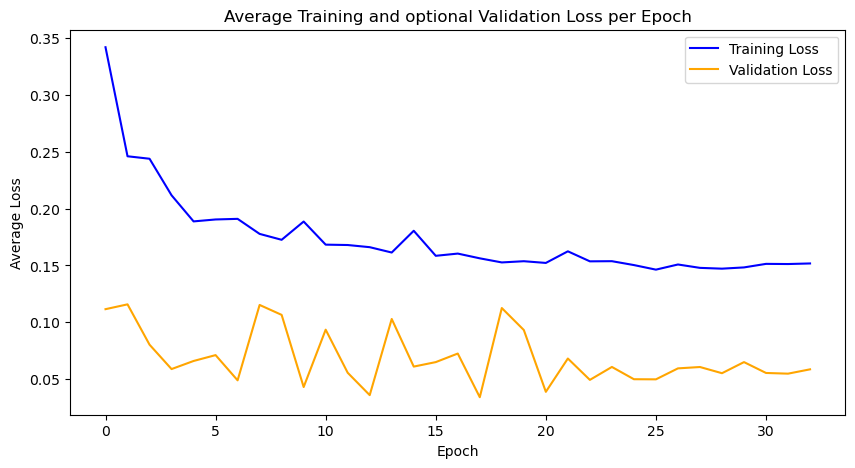

In [30]:
from inception_net_config import inception_config2, inception_config1, inception_config3_complex
from flexible_inception_net import FlexibleInceptionNet
from inception_net import StaticInceptionNet

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

# Define hyperparameters
lambda_reg = None
main_lr = 0.0001976548876041071    
stn_lr = 3.4077218536678756e-05
aux_lr = 2.4657594618999307e-05
max_norm = 1.0     
n_epochs = 100     
patience = 15
weight_decay_stn = 9.079492754108911e-06
weight_decay_main = 6.552486451170475e-05
weight_decay_aux = 1.6129740253312777e-05

# extensions
use_spatial_transformer = True
use_residual = False
use_aux = True
inception_config = inception_config1

# optuna
#best_params = study.best_trial.params

# Instantiate the InceptionNet with the custom configurations
model = FlexibleInceptionNet(
    num_keypoints=68, inception_configs=inception_config, use_spatial_transform=use_spatial_transformer, use_residual=use_residual, use_aux=use_aux
)

model.to(device)

# Get current datetime in a formatted string
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

criterion = nn.SmoothL1Loss()

import torch.optim as optim

# Check if the model has an stn attribute
if hasattr(model, 'stn'):
    # Get parameters of stn
    stn_params = list(model.stn.parameters())
    stn_param_ids = list(map(id, stn_params))
else:
    stn_params = []
    stn_param_ids = []

# Check if the model has auxiliary classifiers
if hasattr(model, 'auxiliary_classifiers'):
    # Get parameters of auxiliary classifiers
    aux_params = list(model.auxiliary_classifiers.parameters())
    aux_param_ids = list(map(id, aux_params))
else:
    aux_params = []
    aux_param_ids = []
    
# Get parameters of the rest of the model by filtering out stn parameters
# Filter out stn and auxiliary classifier parameters to get the main network parameters
rest_params = [
    param for param in model.parameters()
    if id(param) not in stn_param_ids and id(param) not in aux_param_ids
]

# # Define the optimizer with parameter groups
optimizer = optim.Adam([
    {'params': rest_params, 'weight_decay': weight_decay_main, 'lr': main_lr},   # Parameters of the main network
    {'params': stn_params, 'weight_decay': weight_decay_stn, 'lr': stn_lr},      # Parameters of the stn
    {'params': aux_params, 'weight_decay': weight_decay_aux, 'lr': aux_lr}       # Auxiliary classifiers
])

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# log hyperparameters for each experiment
# Create a SummaryWriter instance
writer = SummaryWriter(log_dir=f"logs/runs/{model.__class__.__name__}_{current_time}")

# Log hyperparameters as text
hyperparams_text = f"""
### Hyperparameters

Net specific parameters:

- **Channel configuration (Inception)**: {inception_config}
- **Use residual**: {use_residual}
- **Use aux**: {use_aux}
- **Aux Learning rate**: {aux_lr}
- **Weight Decay for STN Learning Rate**: {weight_decay_stn}
- **Weight Decay Main Learning Rate**: {weight_decay_main}
- **Weight Decay Aux Learning Rate**: {weight_decay_aux}
- **Lambda regulation**: {'Used: ' + str(lambda_reg) if hasattr(model, 'stn') else 'Not used'}
- **Main Learning rate**: {main_lr}
- **STN Learning rate**: {'Used: ' + str(stn_lr) if hasattr(model, 'stn') else 'Not used' }
- **Gradient Clipping Max Norm**: {max_norm}
- **Max Number of Epochs**: {n_epochs}
- **Batch Size**: {train_loader.batch_size}
- **Optimizer**: {optimizer.__class__.__name__}
- **Loss Function**: {criterion.__class__.__name__}
- **Patience**: {patience}
- **Scheduler**: {'Used' if lr_scheduler else 'Not used'}
"""
writer.add_text('Hyperparameters', hyperparams_text)

# train your network
train_losses, val_losses, best_loss = train_net(
    model, n_epochs, optimizer, criterion, train_loader=train_loader, valid_loader=valid_loader, patience=patience, lr_scheduler=lr_scheduler, lambda_reg=lambda_reg, max_norm_gradient_clipping=max_norm, logging=True)

# Visualize the training loss
plot_epoch_loss(train_losses, valid_losses=val_losses)


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

Average Mean Absolute Error on the test set: 7.4617


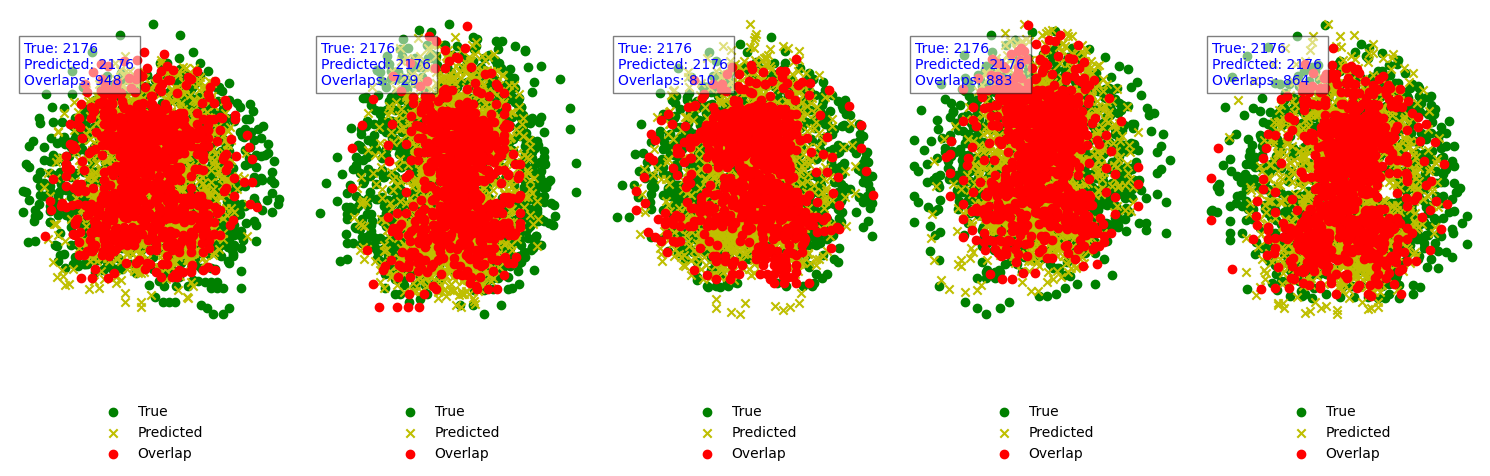

7.461655139923096

In [26]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, test_loader, device, num_batch_samples):
    """
    Evaluate the trained model on the test set and compute the average error.
    
    Args:
        model: The trained model to evaluate.
        test_loader: DataLoader for the test dataset.
        device: Device on which to perform the computations ('cuda' or 'cpu').
    
    Returns:
        avg_loss: Average Mean Absolute Error (MAE) loss over the test set.
    """

    def visualize_predictions(predictions, true_keypoints, num_batch_samples=5, overlap_threshold=2.0):
        """
        Visualize a few test images with predicted, true, and overlapping keypoints.
        
        Args:
            predictions: List of predicted keypoints.
            true_keypoints: List of true keypoints.
            num_batch_samples: Number of samples to visualize.
            overlap_threshold: Distance threshold below which points are considered overlapping.
        """
        fig, axs = plt.subplots(1, num_batch_samples, figsize=(15, 5))
        for i in range(num_batch_samples):
            pred_kpts = predictions[i].reshape(-1, 2)
            true_kpts = true_keypoints[i].reshape(-1, 2)
    
            # Initialize lists to store separate points
            true_points = []
            pred_points = []
            overlap_points = []
    
            # Check each true keypoint against predicted keypoints for overlaps
            for t_pt, p_pt in zip(true_kpts, pred_kpts):
                distance = np.linalg.norm(t_pt - p_pt)
                if distance < overlap_threshold:
                    overlap_points.append(t_pt)  # Add to overlap if within the threshold
                else:
                    true_points.append(t_pt)  # Non-overlapping true point
                    pred_points.append(p_pt)  # Non-overlapping predicted point
    
            # Convert lists to arrays for easy plotting
            true_points = np.array(true_points)
            pred_points = np.array(pred_points)
            overlap_points = np.array(overlap_points)
    
            # Plot true points, predicted points, and overlapping points with different colors
            if true_points.size > 0:
                axs[i].scatter(true_points[:, 0], true_points[:, 1], c='g', marker='o', label='True')
            if pred_points.size > 0:
                axs[i].scatter(pred_points[:, 0], pred_points[:, 1], c='y', marker='x', label='Predicted')
            if overlap_points.size > 0:
                axs[i].scatter(overlap_points[:, 0], overlap_points[:, 1], c='r', marker='o', label='Overlap')
    
            # Display counts for true, predicted, and overlapping points
            num_true = len(true_kpts)
            num_pred = len(pred_kpts)
            num_overlaps = len(overlap_points)
    
            axs[i].text(0.05, 0.9, f'True: {num_true}\nPredicted: {num_pred}\nOverlaps: {num_overlaps}',
                        transform=axs[i].transAxes, fontsize=10, color='blue', verticalalignment='top',
                        bbox=dict(facecolor='white', alpha=0.5))
    
            # Set legend below the plot with vertical alignment
            axs[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=1, fontsize=10, frameon=False)
            axs[i].axis('off')
    
        plt.tight_layout()
        plt.show()

    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_true_keypoints = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for i, sample in enumerate(test_loader):
            images = sample['image'].to(device)  # Move images to the device
            true_keypoints = sample['keypoints'].to(device)  # Move true keypoints to the device

            # Forward pass: Predict keypoints
            predictions, _, _ = model(images)
            
            # Denormalize the predictions and true keypoints
            predictions_denorm = predictions * 50 + 100
            true_keypoints_denorm = true_keypoints * 50 + 100
            
            # Calculate Mean Absolute Error for each sample in the batch
            loss = mean_absolute_error(true_keypoints_denorm.cpu().view(-1).numpy(),
                                       predictions_denorm.cpu().view(-1).numpy())
            total_loss += loss

            # Store predictions, true keypoints, and images for visualization
            all_predictions.append(predictions_denorm.cpu().numpy())
            all_true_keypoints.append(true_keypoints_denorm.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Average Mean Absolute Error on the test set: {avg_loss:.4f}")

    # Visualize a few predictions
    visualize_predictions(all_predictions, all_true_keypoints, num_batch_samples=num_batch_samples, overlap_threshold=8.0)
    return avg_loss


# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

# Run the test routine
evaluate_model(model, test_loader, device, num_batch_samples=5)


Sample 0: 7 keypoints out of range.
Sample 0 - Min value: -0.8343082666397095, Max value: 1.214279055595398
Sample 1: 15 keypoints out of range.
Sample 1 - Min value: -0.5557550191879272, Max value: 1.3859021663665771
Sample 2: 12 keypoints out of range.
Sample 2 - Min value: -0.6621854305267334, Max value: 1.3704551458358765
Sample 3: 13 keypoints out of range.
Sample 3 - Min value: -0.5377753973007202, Max value: 1.3971055746078491
Sample 4: 3 keypoints out of range.
Sample 4 - Min value: -0.6589600443840027, Max value: 1.1640806198120117

Checked 5 samples.
Total keypoints out of range: 50
Overall min keypoint value: -0.8343082666397095
Overall max keypoint value: 1.3971055746078491

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])
['Angelo_Reyes_50.jpg', 'Clay_Aiken_51.jpg', 'Janis_Ruth_Coulter_50.jpg', 'Philippe_Noiret_51.jpg', 'Charlie_Coles_10.jpg']


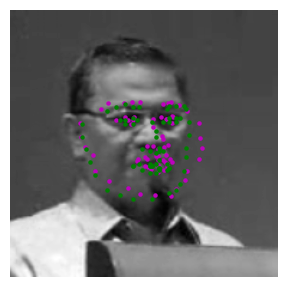

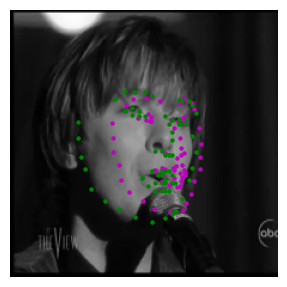

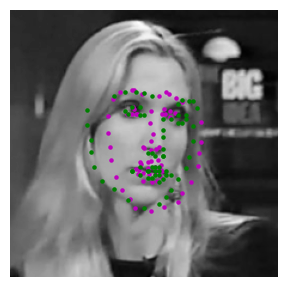

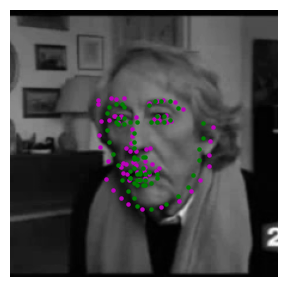

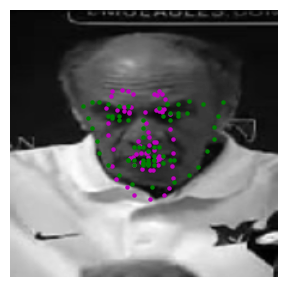

In [28]:
# get a sample of test data again
test_images, test_outputs, gt_pts, names = net_sample_output(model, test_loader)
check_predicted_keypoints(test_outputs, sample_size=5, details=True)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())
print(names[:5])

## visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts, batch_size=5)

Another debug function: (sadly the debugger of my PyCharm environment did not work.

In [50]:
def inspect_data_types(data, depth=2, current_depth=0):
    """
    Recursively inspects data types within a nested structure up to a specified depth.
    
    Args:
    - data: The data structure to inspect (e.g., dict, list, tuple).
    - depth: The maximum depth to inspect.
    - current_depth: The current depth in recursion (default is 0).

    Returns:
    - A nested structure representing data types.
    """
    if current_depth >= depth:
        return type(data)

    if isinstance(data, dict):
        return {key: inspect_data_types(value, depth, current_depth + 1) for key, value in data.items()}

    elif isinstance(data, list):
        return [inspect_data_types(item, depth, current_depth + 1) for item in data]

    elif isinstance(data, tuple):
        return tuple(inspect_data_types(item, depth, current_depth + 1) for item in data)

    else:
        return type(data)


Once you've found a good model (or two), save your model so you can load it and use it later!

This here is a test with an image from the train, valid or test loader.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading image: data/test/Manuel_Pellegrini_20.jpg
Before processing:
  - Red channel:   min=0, max=255
  - Green channel: min=0, max=250
  - Blue channel:  min=0, max=255
After grayscale conversion: min=3, max=251

After division by 255: min=0.011764705882352941, max=0.984313725490196

After z-score normalization: min=-1.5025130704922587, max=2.6733092550029887

Keypoints normalized: min=-0.6944, max=1.4573913043478262

After transformation - min pixel value: -1.50251305103302, max pixel value: 2.673309326171875


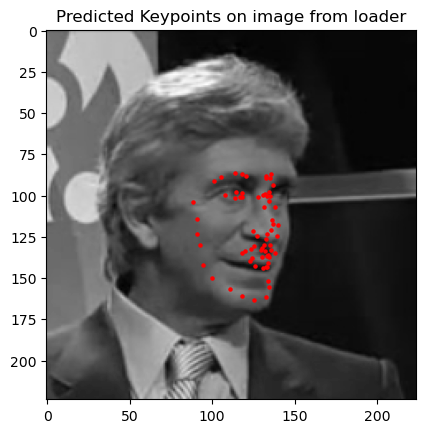

<class 'torch.Tensor'>


In [17]:
%load_ext autoreload
%autoreload 2

from data_load import FacialKeypointsDataset
from data_load import Resize, RandomCrop, Normalize, ToTensor, RandomRotate, RandomHorizontalFlip, FaceCrop

# Define the target name to look for
#target_name = "Charlotte_Casiraghi_21.jpg"
target_name = "Manuel_Pellegrini_20.jpg"
#target_name = "Martin_Sheen_50.jpg"

for batch in test_loader:
    images = batch['image']
    keypoints = batch['keypoints']
    names = batch['name']

    # Check if target_name is in the current batch's 'name' list
    if target_name in names:
        idx = names.index(target_name)
        sample = {
            'image': images[idx],
            'keypoints': keypoints[idx],
            'name': names[idx]
        }

# Select the first image from the batch
working_image = sample['image'].unsqueeze(0)  # Adding batch dimension

# Move the image to the device (e.g., CUDA if available)
working_image = working_image.to(device)

# Ensure the model is in evaluation mode and on the correct device
model.eval()
model.to(device)

# Perform the prediction with no gradient tracking
with torch.no_grad():
    output, _, _ = model(working_image)

predicted_keypoints = output.cpu().view(-1, 2)  # Reshape to (68, 2) if expecting 68 keypoints
predicted_keypoints = predicted_keypoints * 50.0 + 100

# Visualize the result
image_np = working_image.cpu().squeeze().numpy()  # Convert to numpy for display if necessary
plt.imshow(image_np, cmap='gray')
plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='.', c='r')
plt.title("Predicted Keypoints on image from loader")
plt.show()

print(f"{type(working_image)}")

And this here tries to predict an individual image.

In [21]:
def compare_images_properties(img1, img2):
    properties = {}

    # Compare shapes
    properties['Shape'] = (img1.shape, img2.shape)

    # Pixel intensity range
    properties['Range'] = ((img1.min().item(), img1.max().item()), (img2.min().item(), img2.max().item()))

    # Mean and standard deviation of pixel intensities
    properties['Mean'] = (torch.mean(img1).item(), torch.mean(img2).item())
    properties['Std Dev'] = (torch.std(img1).item(), torch.std(img2).item())

    # Normalization check
    properties['Normalized (0-1 range)'] = (
        img1.min() >= 0 and img1.max() <= 1,
        img2.min() >= 0 and img2.max() <= 1,
    )

    return properties


<class 'torch.Tensor'> / <class 'torch.Tensor'>
Shape: exploding kpts image 1 - torch.Size([1, 1, 224, 224]), Working Image 2 - torch.Size([1, 1, 224, 224])
Range: exploding kpts image 1 - (0.0031021784525364637, 0.9960784316062927), Working Image 2 - (-1.2999999523162842, 2.594459295272827)
Mean: exploding kpts image 1 - 0.6758257150650024, Working Image 2 - 1.0582538843154907
Std Dev: exploding kpts image 1 - 0.31107962131500244, Working Image 2 - 1.411110520362854
Normalized (0-1 range): exploding kpts image 1 - True, Working Image 2 - False


In [23]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_FlexibleInceptionNet_config1_aux_good_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(model.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I chose the SmoothL1Loss function because it has adaptive L1 regularization in it. For the optimizer I chose the tried-and-tested ADAM optimizer with its integrated momentum functionality. Because of my architecture I have three separate learning rates: one for the main net, one for the aux classifier and one for the spatial transformer.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

The chosen architecture combines a custom InceptionNet with spatial transformer and auxiliary classifier components to achieve more accurate and robust keypoint detection. The primary InceptionNet modules employ different convolutional paths in parallel, which capture various levels of spatial detail and provide a comprehensive representation of features at different resolutions. Using parallel paths in each module allows the model to focus on both local and global structures in the input image, which is crucial for detecting facial landmarks accurately.

The spatial transformer network (STN) adds a unique capability to the model by dynamically learning affine transformations to align and normalize the input data. This component is particularly useful for keypoint detection on faces with varied orientations and scales, as it helps the network focus on regions of interest and reduce the impact of outliers or shifts in alignment. The STN introduces spatial invariance, allowing the network to generalize better to different facial poses without requiring manually adjusted preprocessing steps.

The auxiliary classifier enhances the network by supporting the main InceptionNet with additional intermediate supervision. By adding auxiliary losses at select points in the network, it effectively guides the early layers to learn more meaningful features that directly contribute to the final predictions. This intermediate feedback provides stability to the network during training, helping it avoid overfitting on specific layers. The inclusion of auxiliary classifiers is strategically configured so that they are only activated during training, enhancing the model's performance without introducing extra computational complexity at inference time.

A unique aspect of this architecture is its flexibility in configuration. The network’s inception modules can be adjusted easily to experiment with different structures, allowing for quick changes to channel sizes, kernel sizes, and even the number of branches within each module. This modular design lets the architecture adapt to various levels of complexity, making it suitable for experimentation and fine-tuning to the specific needs of the keypoint detection task.









### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

Batch size:

I checked my hardware and the ram occupation of my GPU ram. Then I set the batch size accordingly so that it is a) not to small, and b) fits in my GPU memory. 

Epochs:

I implemented an early stopping mechanism in my training so the epochs are decided dynamically based on the validation loss. I set a patience of 15 so that the net has enough tries to find a good solution.


## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.11118409  0.03877578 -0.0263174   0.01986184  0.11011753  0.06605959
  -0.06433579]
 [-0.06670388 -0.06847914 -0.124396    0.07839046  0.07641288  0.07477937
   0.05570685]
 [-0.14377286  0.05378928  0.07464423 -0.04743401  0.13042885 -0.11872809
  -0.0234449 ]
 [ 0.03107185 -0.11351452  0.07897514 -0.10693576  0.01399449  0.0207335
  -0.08081413]
 [-0.07837006 -0.02321061 -0.09194054 -0.02559503 -0.00889533  0.01002957
   0.01210094]
 [-0.00854754 -0.02348691 -0.06458642 -0.0631567   0.12632662  0.03863844
   0.12239051]
 [ 0.02440853  0.02049336 -0.09863707  0.12393197  0.07524043 -0.10093398
  -0.08448061]]
(7, 7)


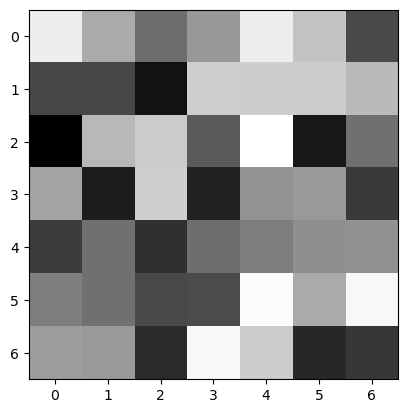

In [32]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = model.conv1[0].weight.data.cpu()

w = weights1.numpy()

filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

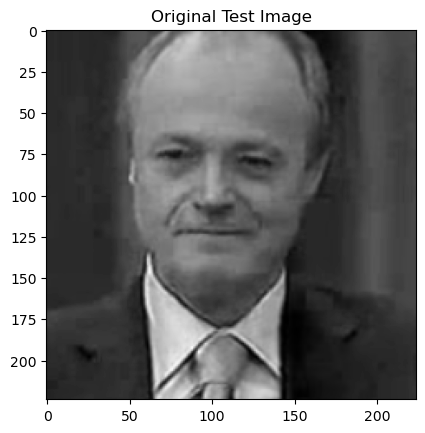

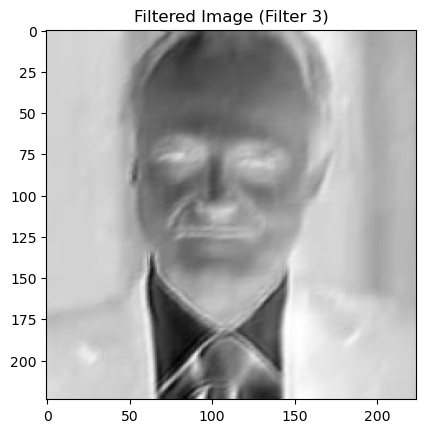

In [61]:
## load in and display any image from the transformed test dataset

## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
# Step 1: Load a test image (assuming you have a sample image from the dataset)
# Select the first test image from the test_loader (or load any image for testing)

import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_test_image(test_loader):
    for i, sample in enumerate(test_loader):
        test_image = sample['image'][0].cpu().numpy()  # get first image in the batch
        # Remove the batch and channel dimensions for visualization
        test_image = np.squeeze(test_image)
        return test_image

# Load a test image
test_image = load_test_image(test_loader)

# Display the test image
plt.imshow(test_image, cmap='gray')
plt.title('Original Test Image')
plt.show()

filter_index = 3
filter_weights = w[filter_index][0]  # Extract the first filter

# Apply the 2D convolution (filter2D expects a 2D image, so we ensure the image is 2D)
filtered_image = cv2.filter2D(test_image, -1, filter_weights)

# Display the filtered image
plt.imshow(filtered_image, cmap='gray')
plt.title(f'Filtered Image (Filter {filter_index})')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: It is not easy for me to interpret the meaning of the filters. For example filter 4 (index 3) inverses bright and dark areas (so it seems). This could indicate the following functions: 

1. High-Pass Filtering (Edge Detection):
This type of filter emphasizes high-frequency details in the image, such as edges, by detecting areas of rapid intensity change (e.g., between bright and dark regions).
Getting a negative-like appearance, it usually means that the filter is sensitive to rapid transitions in pixel intensity and inverts the transition. Areas with little change (like flat regions of the face) might become darker, while regions with significant intensity change (like edges or features like eyes, nose, etc.) might appear lighter or inverted.


2. Feature Inversion:
The filter might be inverting certain high-level features such as brightness, where normally bright features become dark and dark features become bright. This often occurs in filters designed to negate certain feature activations or focus on contrasts.


---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!